In [34]:
import csv
import SimpleITK as sitk
from PIL import Image
import os
import cv2
import numpy as np
import os
import glob
import scipy
import matplotlib.pyplot as plt
import pydicom
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pypinyin
import time
from glob import glob


def readAllmhd(sourceFolder):
    ddir = []
    for root, dirs, files in os.walk(sourceFolder):
        for name in files:
            path = os.path.join(root, name)
            if path[-4:] == ".mhd":
                ddir.append(path)
    return list(set(ddir))


def load_itk_image(filename):
    with open(filename) as f:
        contents = f.readlines()
        line = [k for k in contents if k.startswith("TransformMatrix")][0]
        transform = np.array(line.split(" = ")[1].split(" ")).astype("float")
        transform = np.round(transform)
        if np.any(transform != np.array([1, 0, 0, 0, 1, 0, 0, 0, 1])):
            isflip = True
        else:
            isflip = False
    itkimage = sitk.ReadImage(filename)
    numpyimage = sitk.GetArrayFromImage(itkimage)  # [z,x,y]
    if isflip == True:
        numpyimage = numpyimage[:, ::-1, ::-1]
    numpyOrigin = np.array(list(itkimage.GetOrigin()))  # CT原点坐标[x,y,z]
    numpyOrigin = np.hstack((numpyOrigin[2], numpyOrigin[:2]))  # [z,x,y]
    numpySpacing = np.array(list(itkimage.GetSpacing()))  # CT像素间隔[x,y,z]
    numpySpacing = np.hstack((numpySpacing[2], numpySpacing[:2]))  # [z,x,y]
    return numpyimage, numpyOrigin, numpySpacing


# 坐标转化
def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord


# ########################################################
# def normalizePlanes(npzarray):
#     maxHU = 400.0
#     minHU = -1000.0
#     npzarray = (npzarray - minHU) / (maxHU - minHU)
#     npzarray[npzarray > 1] = 1.0
#     npzarray[npzarray < 0] = 0.0
#     return npzarray


# #########################################################
# def truncate_hu(image_array):
#     image_array[image_array > 400] = 0
#     image_array[image_array < -1000] = 0


# def normalization(image_array):
#     ImgArrmax = image_array.max()
#     ImgArrmin = image_array.min()
#     image_array = (image_array - ImgArrmin) / (ImgArrmax - ImgArrmin)
#     avg = image_array.mean()
#     image_array = image_array - avg
#     return image_array
# #########################################################
def draw3DLinearTrans(image, HU_mean=-1200, HU_Diameter=1000):
    N = len(image)
    HU_upper = HU_mean + HU_Diameter * 0.5
    HU_lower = HU_mean - HU_Diameter * 0.5
    # assert the slice qualification
    for slice_number in range(N):
        image[slice_number][image[slice_number] > 3095] = 0
        image[slice_number] = image[slice_number] * (image[slice_number] > HU_lower) * (image[slice_number] < HU_upper) + HU_upper * (image[slice_number] > HU_upper) + HU_lower * (image[slice_number] < HU_lower)
    return image, HU_lower, HU_upper


def resample(image, spacing, new_spacing=[1, 1, 1]):
    # scan是原始的slices
    # Determine current pixel spacing
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode="nearest")
    return image, new_spacing


def segment_lung_mask(image, fill_lung_structures=True):
    # not actually binary, but 1 and 2.
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8) + 1  ## 图像变为 1 and 2
    labels = measure.label(binary_image)  ## 连通域
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air
    #   around the person in half
    background_label = labels[0, 0, 0]  ## 最上角一定是空气
    # Fill the air around the person
    binary_image[background_label == labels] = 2  ## 跟空气连接在一起的判定为空气
    # Method of filling the lung structures (that is superior to something like
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1  ## 0 1
            labeling = measure.label(axial_slice)  ## 当前slice的连通域
            l_max = largest_label_volume(labeling, bg=0)  ### 数量最多的标签
            if l_max is not None:  # This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    binary_image -= 1  # Make the image actual binary 0 1
    binary_image = 1 - binary_image  # Invert it, lungs are now 1
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None:  # There are air pockets
        binary_image[labels != l_max] = 0
    return binary_image


def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]  ## 不是-1的值
    if len(counts) > 0:
        return vals[np.argmax(counts)]  ## 数量最多的值
    else:
        return None


def save_3d(image, filename, threshold=400):
    # Position the scan upright,
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2, 1, 0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(p, threshold)  #### ？？？？
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()
    #plt.savefig(filename)
    plt.close("all")
    print("plot 3d image down")


def ToLung_npy(myimage, D, path1, threshold):
    # threshold is the n more pixel we need to assure the completeness
    # myslices = arrangeSlice(folderpath,sshape = (512,512))
    # myimage = get_pixels_hu(myslices)
    # segmented_lungs = segment_lung_mask(myimage, False)
    # D=segmented_lungs
    # result = np.zeros(D.shape)
    nx, ny, nz = D.shape
    # 第三个维度上的max，min
    zmin = np.nonzero(np.sum(np.sum(D, 0), 0).flatten())[0][0]
    zmax = np.nonzero(np.sum(np.sum(D, 0), 0).flatten())[0][-1]
    # 第二个维度上的max，min
    ymin = np.nonzero(np.sum(np.sum(D, 0), 1).flatten())[0][0]
    ymax = np.nonzero(np.sum(np.sum(D, 0), 1).flatten())[0][-1]
    # 第一个维度上的max，min
    xmin = np.nonzero(np.sum(np.sum(D, 2), 1).flatten())[0][0]
    xmax = np.nonzero(np.sum(np.sum(D, 2), 1).flatten())[0][-1]
    final_xleft = max(0, xmin - threshold)
    final_yleft = max(0, ymin - threshold)
    final_zleft = max(0, zmin - threshold)
    final_xright = min(nx, xmax + threshold)
    final_yright = min(ny, ymax + threshold)
    final_zright = min(nz, zmax + threshold)
    result = myimage[final_xleft:final_xright, final_yleft:final_yright, final_zleft:final_zright]
    np.save(path1, result, allow_pickle=True, fix_imports=True)


def PathToFilename(path):
    filename = os.path.split(path)[-1].replace(".mhd", "")
    return filename

In [51]:
img_path = "data/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd"
imgarray_temp, nporg1, npspc1 = load_itk_image(img_path)
np.unique(imgarray_temp)
# save_3d(imgarray_temp, 'test.png', threshold=0)

array([0, 3, 4, 5], dtype=int16)

In [18]:
Folder1 = "data/subset0"

FileList=readAllmhd(Folder1)
NowList = os.listdir("./Extract_base_seg")
for i in range(len(FileList)):
    path = FileList[i]
    name = PathToFilename(path)
    npypath = os.path.join("./Extract_base_seg",name + ".npy")
    segpath = os.path.join("data/seg-lungs-LUNA16",name + ".mhd")
    if not ((name + ".npy") in NowList):
        

/Users/chromium/opt/anaconda3/envs/image/lib/python3.7/site-packages/ipykernel_launcher.py:150: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19


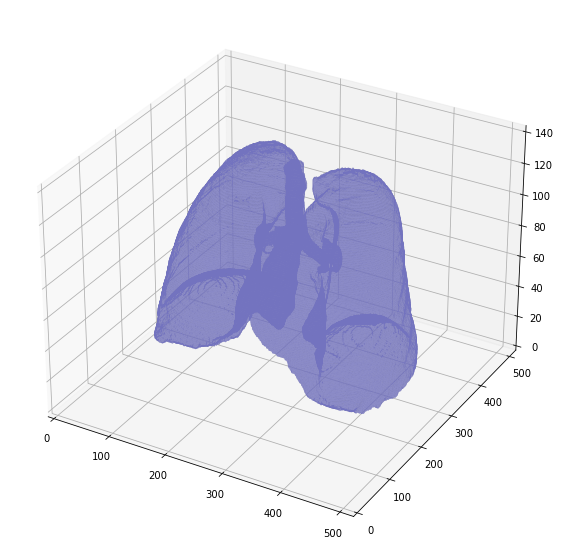

plot 3d image down


In [52]:
path=FileList[0]
name = PathToFilename(path)
npypath = os.path.join("./Extract_base_seg",name + ".npy")
segpath = os.path.join("data/seg-lungs-LUNA16",name + ".mhd")
if not ((name + ".npy") in NowList):
    imgarray_original, nporg, npspc = load_itk_image(path)
    imgarray_seg, nporg1, npspc1 = load_itk_image(segpath)
    imgarray = imgarray_original.copy()
    imgarray[imgarray_seg==0]=0
    save_3d(imgarray_seg, 'test.png', threshold=0)
    
#     if imgarray.shape[0] > 10:
#         if int(npspc[0]) <= 3:
#             myimage, new_spacing = resample(imgarray, npspc, new_spacing=[1, 1, 1])

In [56]:
test1=np.load("./Round1/AAAdata-subset0-1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371.npy")
np.unique(test1)

array([-1303, -1293, -1274, ...,   754,   760,   763], dtype=int16)

In [ ]:
imgarray_3=imgarray.copy()
imgarray_4=imgarray.copy()
imgarray_5=imgarray.copy()
imgarray_3[imgarray!=3]=0
imgarray_4[imgarray!=4]=0
imgarray_5[imgarray!=5]=0
save_3d(imgarray_3, 'imgarray_3.png', threshold=0)
save_3d(imgarray_4, 'imgarray_4.png', threshold=0)
save_3d(imgarray_5, 'imgarray_5.png', threshold=0)

In [ ]:
if imgarray.shape[0] > 10:
    if int(npspc1[0]) <= 10:
        myimage, new_spacing = resample(imgarray, npspc1, new_spacing=[1, 1, 1])
        print(myimage.shape)
        segmented_lungs_fill = segment_lung_mask(myimage, True)
        save_3d(segmented_lungs_fill, img_path, threshold=0)
        plt.close()

In [ ]:
Folder1 = "data/subset0"
def ExtractLungRound1(sourceFolder):
    FileList = readAllmhd(Folder1)
    NowList = os.listdir("./Round1")
    for i in range(len(FileList)):
        path = FileList[i]
        pngname = PathToFilename(path)
        pngpath = os.path.join("./Round1", pngname + ".png")
        npypath = os.path.join("./Round1", "AAA" + pngname + ".npy")
        print(pngpath)
        print(npypath)
        if not ((pngname + ".png") in NowList):
            imgarray_original, nporg, npspc = load_itk_image(path)
            imgarray, u1, u2 = draw3DLinearTrans(imgarray_original, HU_mean=-300, HU_Diameter=1400)
            if imgarray.shape[0] > 10:
                if int(npspc[0]) <= 3:
                    myimage, new_spacing = resample(imgarray, npspc, new_spacing=[1, 1, 1])
                    segmented_lungs_fill = segment_lung_mask(myimage, True)
                    save_3d(segmented_lungs_fill, pngpath, threshold=0)
                    ToLung_npy(myimage, segmented_lungs_fill, npypath, threshold=5)

In [ ]:
file_list = glob("data/seg-lungs-LUNA16/*.mhd")
for i in range(len(file_list)):
    path=file_list[i]
    pngname=PathToFilename(path)
    pngpath=os.path.join("./Sug_Lung", pngname + ".png")
    if not ((pngname + ".png") in NowList):
        imgarray_original, nporg, npspc = load_itk_image(path)
        imgarray, u1, u2 = draw3DLinearTrans(imgarray_original, HU_mean=-300, HU_Diameter=1400)
        if imgarray.shape[0] > 10:
            if int(npspc[0]) <= 3:
                myimage, new_spacing = resample(imgarray, npspc, new_spacing=[1, 1, 1])
                save_3d(myimage,pngpath,threshold=0)

In [ ]:
path1='data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd'
path2='data/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd'
imgarray_original1, nporg1, npspc1 = load_itk_image(path1)
imgarray1, u11, u21 = draw3DLinearTrans(imgarray_original1, HU_mean=-300, HU_Diameter=1400)
imgarray_original2, nporg2, npspc2 = load_itk_image(path2)
imgarray2, u12, u22 = draw3DLinearTrans(imgarray_original2, HU_mean=-300, HU_Diameter=1400)
print(np.unique(imgarray_original1))
print(np.unique(imgarray1[imgarray2==3]))
print(np.unique(imgarray_original2))
print(np.unique(imgarray2))